In [1]:
from lineage.AffMB import *
import pandas as pd
import os
import scanpy as sc
import anndata
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torch
from collections import Counter
import scipy.stats as stats
from scipy.signal import argrelextrema
import matplotlib as mpl
import brewer2mpl
from statannotations.Annotator import Annotator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


Matplotlib is building the font cache; this may take a moment.


In [8]:
proligenes = ["MKI67", "PLK1", "E2F1", "FEN1", "FOXM1", "MCM2", "MCM7", "BUB1", "CCNE1", "CCND1", 
             "CCNB1", "TOP2A", "MYBL2", "BUB1", "PLK1", "ZWINT", "TYMS", "PCNA", "H2AFZ", "HMGB2", 
             "TCL1A", "CD79B", "CD79A", "MS4A1"]
exhaustgenes = ['FCRL4', 'PDCD1', 'SIGLEC6', 'LAIR1', 'CXCR3', 'CD38', 'CD70', 'CD72', 'CD22']
activategenes = ['CD69', 'CD83', 'IER2', 'DUSP2', 'IL6', 'NR4A2', 'JUN', 'CCR7', 'GPR183', 'IRF4', 'MYC']

In [ ]:
adata = sc.read_h5ad("integrated/raw_count.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
assert(adata.obs.index.tolist() == new_adata.obs.index.tolist())
adata.obs = new_adata.obs

In [2]:
bcremb = pd.read_csv("/mnt/d/unifiedBCR/benchmark/Embeddings/vaccination_GSE244297/mean_inner01new.pth/embedding.csv").values
gexemb = pd.read_csv("/mnt/d/unifiedBCR/benchmark/Embeddings/vaccination_GSE244297/mean_inner01new.pth/gexembedding.csv").values
datapath = "/mnt/d/BCRdataset/vaccination_GSE244297/integrated"
metadata = pd.read_csv("annotation.csv", index_col="barcode")
bcrfile_path = os.path.join(datapath, "processed_bcr.csv")
bcrfile = pd.read_csv(bcrfile_path, index_col="barcode")
bcrfile['whole_seq'] = bcrfile['fwr1'].str.cat([bcrfile["cdr1"], bcrfile["fwr2"], bcrfile["cdr2"], bcrfile["fwr3"],
                                               bcrfile["cdr3"], bcrfile["fwr4"]])
embeddings = np.concatenate([bcremb, gexemb], axis=1)
embeddings = torch.from_numpy(embeddings)
embeddings = F.normalize(embeddings, dim = -1).numpy()
new_adata = anndata.AnnData(embeddings)
new_adata.obs = metadata
binding = pd.read_csv("integrated/spike_original.csv", index_col="barcode")
new_adata.obs['binding2'] = binding['label']
new_adata.obs['binding2'] = new_adata.obs['binding2'].replace({'spikenegative': 'S-', 'spikepositive': 'S+'})
#new_adata.obs.binding2 = new_adata.obs.binding2.map(binding.label)
new_adata.obs['cdr3'] = pd.read_csv("integrated/processed_bcr.csv").cdr3.tolist()
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(new_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [3]:
new_adata.obs.loc[bcrfile.index.tolist(), 'whole_seq'] = bcrfile['whole_seq']
new_adata.obs.loc[bcrfile.index.tolist(), 'v_gene'] = bcrfile['v_gene']
new_adata.obs.loc[bcrfile.index.tolist(), 'j_gene'] = bcrfile['j_gene']
new_adata.obs.loc[bcrfile.index.tolist(), 'c_gene'] = bcrfile['c_gene']
new_adata.obs['v_gene_family'] = new_adata.obs['v_gene'].str.split('/').str[0].str.extract(r'(IGH[VDJ]\d+)')[0]
new_adata.obs['j_gene_family'] = new_adata.obs['j_gene'].str.split('/').str[0].str.extract(r'(IGH[VDJ]\d+)')[0]
seq_counts = new_adata.obs['whole_seq'].value_counts()
seq_to_id = {seq: f'bcrseq{i+1}' for i, seq in enumerate(seq_counts.index)}
new_adata.obs['whole_seq_label'] = new_adata.obs['whole_seq'].map(seq_to_id)
top20_labels = new_adata.obs['whole_seq_label'].value_counts().head(20).index.tolist()
new_adata.obs['whole_seq_top20'] = new_adata.obs['whole_seq_label'].apply(
    lambda x: x if x in top20_labels else 'Others'
)

<AxesSubplot: title={'center': 'population'}, xlabel='UMAP1', ylabel='UMAP2'>

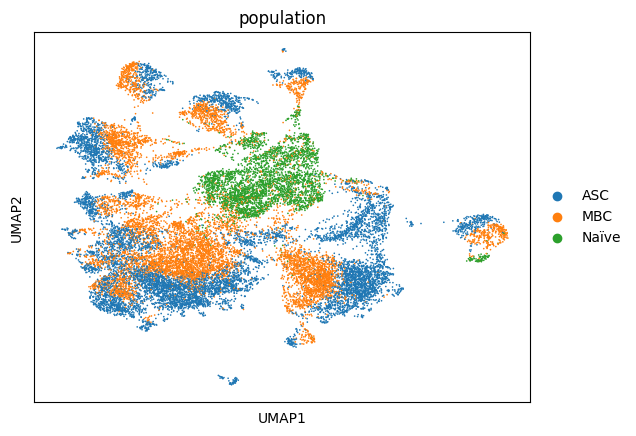

In [ ]:
sc.pl.umap(new_adata, color='population', show=False)
#plt.savefig("/mnt/d/unifiedBCR/figures/GSE244297/3modalities/combcr_v_population.pdf", bbox_inches='tight')

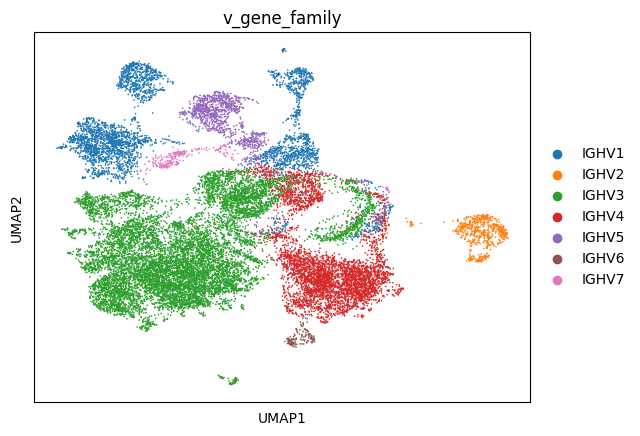

In [ ]:
sc.pl.umap(new_adata, color='v_gene_family', palette='Set2', show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/GSE244297/3modalities/combcr_v_gene_family.pdf", bbox_inches='tight')

         Falling back to preprocessing with `sc.pp.pca` and default params.


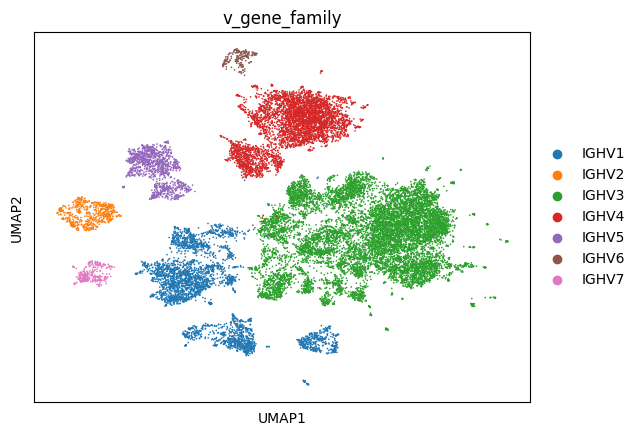

In [5]:
datapath = "/mnt/d/BCRdataset/vaccination_GSE244297/integrated"
antiberta2 = pd.read_csv(os.path.join(datapath, 'antiberta2', 'antiberta_CSSP_embedding.csv'), index_col="barcode")
antiberta2 = anndata.AnnData(antiberta2.values)
antiberta2.obs = new_adata.obs
sc.pp.neighbors(antiberta2, n_neighbors=10, n_pcs=30)
sc.tl.umap(antiberta2)
sc.pl.umap(antiberta2, color='v_gene_family', show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/GSE244297/3modalities/antiberta2_v_gene_family2.pdf", bbox_inches='tight')

         Falling back to preprocessing with `sc.pp.pca` and default params.


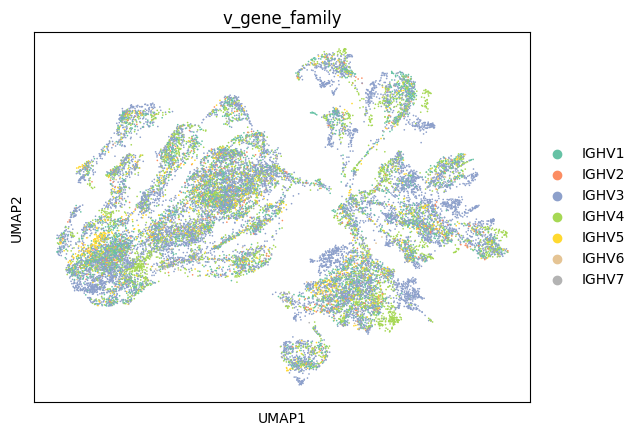

In [7]:
datapath = "/mnt/d/BCRdataset/vaccination_GSE244297/integrated"
rnafile_path = os.path.join(datapath, "processed_rna.csv")
rnafile = pd.read_csv(rnafile_path, index_col="barcode")
orignalgex= anndata.AnnData(rnafile.values)
orignalgex.obs = new_adata.obs
sc.pp.neighbors(orignalgex, n_neighbors=10, n_pcs=30)
sc.tl.umap(orignalgex)
sc.pl.umap(orignalgex, color='v_gene_family', palette='Set2', show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/GSE244297/3modalities/orignalgex_v_gene_family.pdf", bbox_inches='tight')

In [ ]:
gap = pd.DataFrame({'gap': (torch.cdist(torch.from_numpy(bcremb), torch.from_numpy(gexemb))).diagonal().numpy(), 
                     'celltypes':metadata.population.tolist(), "timepoint":metadata.timepoint.tolist(),
                   "binding2": metadata.binding2.tolist(), "isotype": metadata.isotype.tolist()})
gap['barcode'] = metadata.index.tolist()
gap['sample'] = metadata['sample'].tolist()

gap= gap[(gap.celltypes == "MBC") & (gap.binding2 == "S+") & (gap.isotype == "IGHG")]

gap = gap.set_index('barcode', inplace=False)
#sns.violinplot(data=gap, x='celltypes', y='gap')
gap = gap.sort_values(by="gap", ascending=False)
threshold = gap['gap'].quantile(0.9)
gap['difference'] = 'Small'
gap.loc[gap['gap'] >= threshold, 'difference'] = 'Large'
#grouped_df = gap.groupby(['celltypes', 'difference']).size().unstack(fill_value=0)
new_adata.obs.loc[gap.index.tolist(), 'difference'] = gap['difference']
new_adata.obs.loc[gap.index.tolist(), 'gap_value'] = gap['gap']
#sns.violinplot(data=gap, x='celltypes', y='gap')

<AxesSubplot: ylabel='Density'>

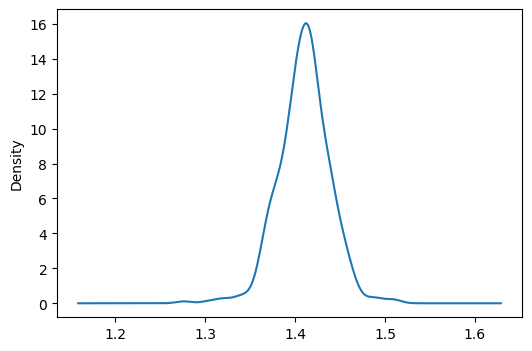

In [14]:
fig, axes = plt.subplots(figsize=(6,4))
gap['gap'].plot.kde(ax=axes)
#plt.savefig("/mnt/d/unifiedBCR/figures/GSE244297/gap_distribution.pdf", bbox_inches='tight')

In [4]:
bcrfile['clonotype.freq'] = bcrfile['whole_seq'].map(bcrfile['whole_seq'].value_counts())
new_adata.obs['clonotype.freq'] = bcrfile['clonotype.freq'].values
new_adata.obs['whole_seq'] = bcrfile['whole_seq'].values


Spearman Correlation (R): 0.039040
P-value: 1.33e-08


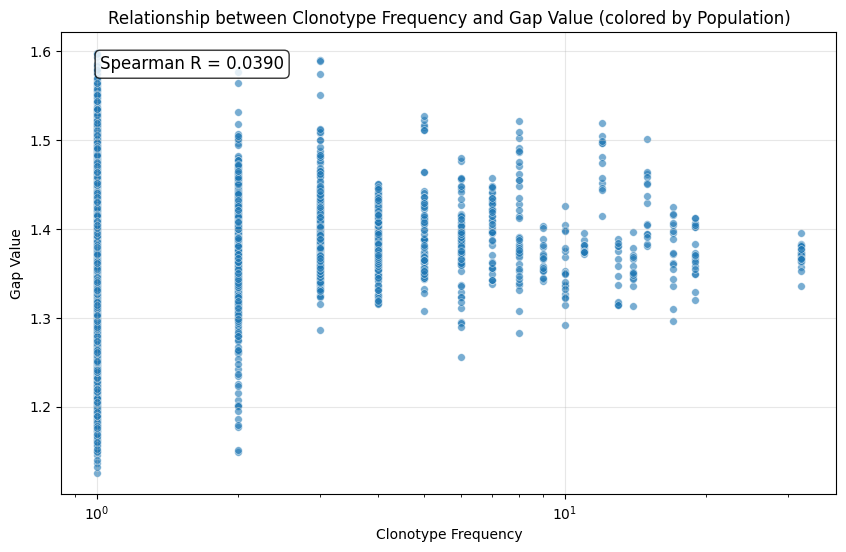

In [ ]:
from scipy.stats import spearmanr

# Calculate correlation coefficient
correlation, p_value = spearmanr(new_adata.obs['clonotype.freq'].values, 
                                new_adata.obs['gap_value'].values)

# Reorder data to plot naive last
population_order = [pop for pop in new_adata.obs['population'].unique() if pop != 'naive']
if 'naive' in new_adata.obs['population'].values:
    population_order.append('naive')

# Rearrange data according to this order
sorted_data = []
for pop in population_order:
    mask = new_adata.obs['population'] == pop
    sorted_data.append(new_adata.obs[mask])

# Concatenate data
sorted_obs = pd.concat(sorted_data, ignore_index=True)

# Create scatter plot with sorted data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sorted_obs, 
                x='clonotype.freq', 
                y='gap_value',
                #hue='population',
                alpha=0.6, 
                s=30,
                palette=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'],
                hue_order=population_order)  # Specify order

# Add correlation coefficient information
plt.text(0.05, 0.95, f'Spearman R = {correlation:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         verticalalignment='top')
plt.xscale('log')
plt.xlabel('Clonotype Frequency')
plt.ylabel('Gap Value')
plt.title('Relationship between Clonotype Frequency and Gap Value (colored by Population)')
plt.grid(True, alpha=0.3)

print(f"Spearman Correlation (R): {correlation:.6f}")
print(f"P-value: {p_value:.2e}")
plt.savefig("/mnt/d/unifiedBCR/figures/GSE244297/gap_clonotype_freq.pdf", bbox_inches='tight')


In [ ]:
gap = pd.DataFrame({'gap': (torch.cdist(torch.from_numpy(bcremb), torch.from_numpy(gexemb))).diagonal().numpy(), 
                     'celltypes':metadata.population.tolist(), "timepoint":metadata.timepoint.tolist(),
                   "binding2": metadata.binding2.tolist(), "isotype": metadata.isotype.tolist()})
gap['barcode'] = metadata.index.tolist()
gap['sample'] = metadata['sample'].tolist()
gap = gap.set_index('barcode', inplace=False)
gap= gap[(gap.celltypes == "MBC") & (gap.binding2 == "S+") & (gap.isotype == "IGHG")]
gap['difference'] = 'Small'

for timepoint in ['pre-I', 'I+1w', 'I+2w', 'I+3w', 'pre-II', 'II+1w', 'II+2w', 'II+3w']:
    sub = gap[gap['timepoint'] == timepoint]
    if sub.shape[0] > 0:
        sub = sub.sort_values(by="gap", ascending=False)
        threshold = sub['gap'].quantile(0.9)
        sub.loc[sub['gap'] >= threshold, 'difference'] = 'Large'
        gap.loc[sub[sub.difference == 'Large'].index.tolist(), 'difference'] = 'Large'
new_adata.obs.loc[gap.index.tolist(), 'difference'] = gap['difference']        

pre-I 0.375
0.1
0.0
0.4
I+1w 0.494949494949495
0.06
0.4
0.5
I+2w 0.8260869565217391
0.0
1.0
0.8095238095238095
I+3w 0.7142857142857143
0.16666666666666666
0.3333333333333333
0.7435897435897436
pre-II 0.41379310344827586
0.11764705882352941
0.0
0.4444444444444444
II+1w 0.358974358974359
0.04
0.5
0.35135135135135137
II+2w 0.504950495049505
0.06
0.5
0.5052631578947369
II+3w 0.5555555555555556
0.08333333333333333
0.4
0.5657894736842105


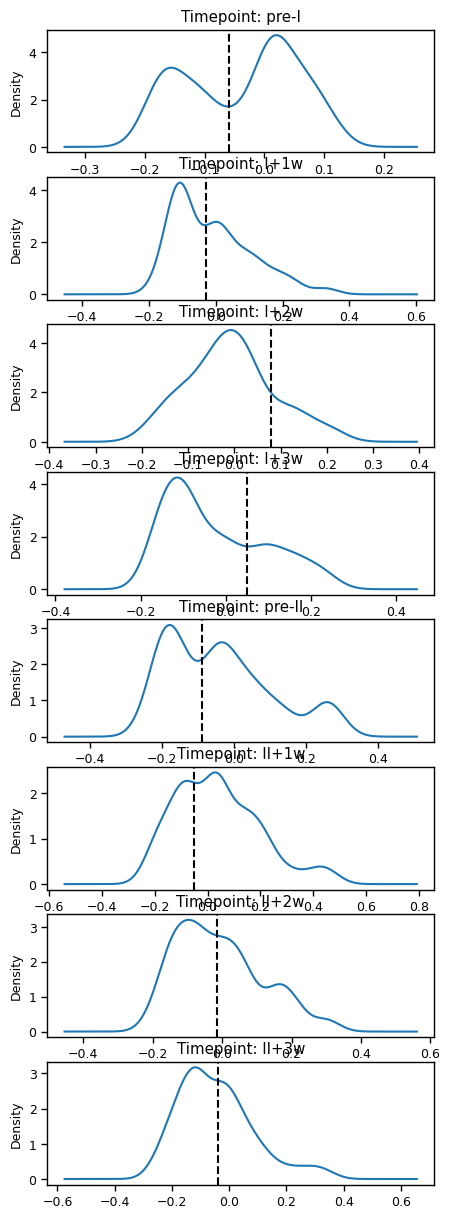

In [14]:
adata = sc.read_h5ad("integrated/raw_count.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
assert(adata.obs.index.tolist() == new_adata.obs.index.tolist())
adata.obs = new_adata.obs

timevalley = {}
exratio = {}
largeexratio = {}
fig, axs = plt.subplots(len(new_adata.obs.timepoint.unique()), 1, figsize=(5, 15))
for i, sampletime in enumerate(['pre-I', 'I+1w', 'I+2w', 'I+3w', 'pre-II', 'II+1w', 'II+2w', 'II+3w']):
    cohort1 = new_adata.obs[(new_adata.obs.binding2=="S+")&(new_adata.obs.timepoint==sampletime)&(new_adata.obs.isotype=="IGHG")&(new_adata.obs.population=="MBC")].index.tolist()
    subobj = adata[cohort1]
    #print(subobj.obs[subobj.obs.difference == "Large"])
    sc.tl.score_genes(subobj, exhaustgenes, ctrl_size=200)
    data = subobj.obs['score']
    
    if sampletime != "I+2w":
        data.plot.kde(ax = axs[i], bw_method=0.3)
    else:
        data.plot.kde(ax = axs[i], bw_method=0.4)
    
    axs[i].set_title(f'Timepoint: {sampletime}')
    xaxis = axs[i].get_children()[0]._x
    yaxis = axs[i].get_children()[0]._y
    xcoords = argrelextrema(yaxis, np.less)[0]
    timevalley['pre-I'] = -0.06; timevalley['I+1w'] = -0.03; timevalley['I+2w'] = 0.08; timevalley['I+3w'] = 0.05
    timevalley['pre-II'] = -0.09; timevalley['II+1w'] = -0.05; timevalley['II+2w'] = -0.015; timevalley['II+3w'] = -0.04
    axs[i].axvline(x=timevalley[sampletime], color='k', linestyle='--')
    
    print(sampletime, len(data.values[data.values < timevalley[sampletime]])/data.shape[0])
    print((subobj.obs.loc[(data.values > timevalley[sampletime]) & (subobj.obs.difference == "Large")]).shape[0]/len(data.values[data.values > timevalley[sampletime]]))
    try:
        print((subobj.obs.loc[(data.values < timevalley[sampletime]) & (subobj.obs.difference == "Large")]).shape[0]/len(subobj.obs[subobj.obs.difference == "Large"]))
        largeexratio[sampletime] = (subobj.obs.loc[(data.values < timevalley[sampletime]) & (subobj.obs.difference == "Large")]).shape[0]/len(subobj.obs[subobj.obs.difference == "Large"])
    except:
        pass
    try:
        print((subobj.obs.loc[(data.values < timevalley[sampletime]) & (subobj.obs.difference == "Small")]).shape[0]/len(subobj.obs[subobj.obs.difference == "Small"]))
    except:
        pass
    exratio[sampletime] = len(data.values[data.values < timevalley[sampletime]])/data.shape[0] #exhaustion低的比例
#plt.savefig("/mnt/d/unifiedBCR/figures/GSE244297/exhaustedscore_timepoints.pdf", bbox_inches='tight')

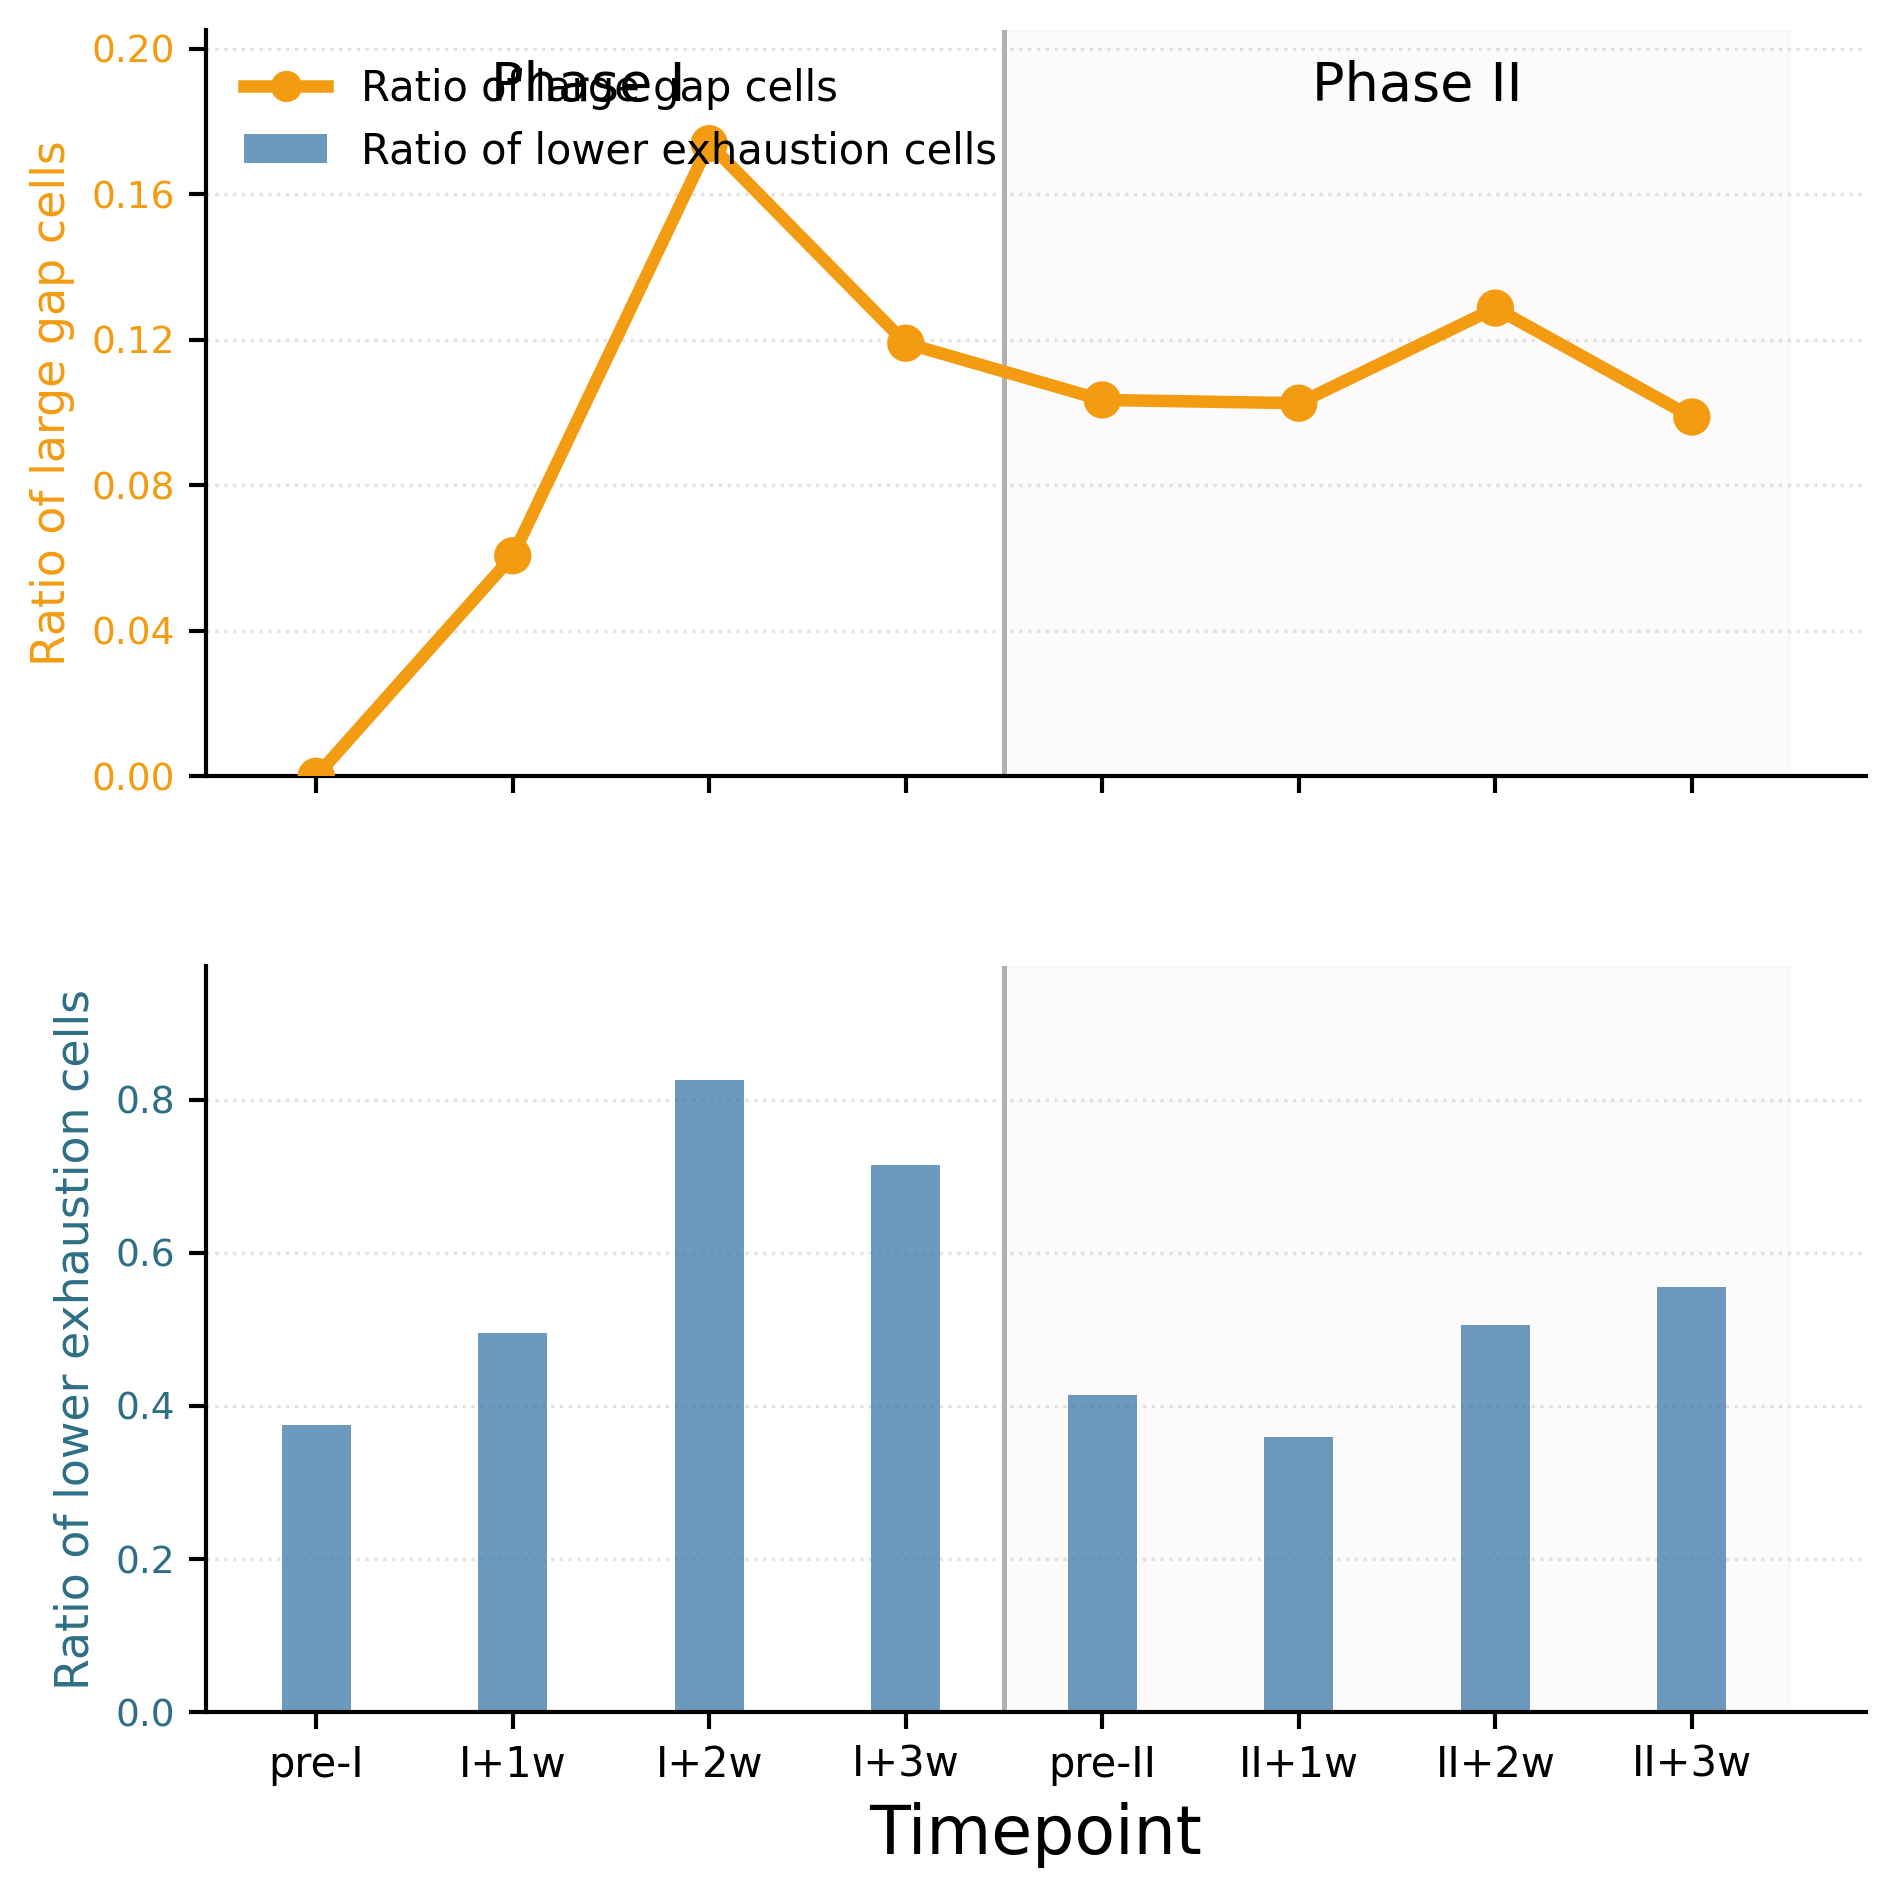

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator

# =========================
# Data preparation
# =========================
gap = pd.DataFrame({
    'gap': (torch.cdist(torch.from_numpy(bcremb), torch.from_numpy(gexemb))).diagonal().numpy(),
    'celltypes': metadata.population.tolist(),
    'timepoint': metadata.timepoint.tolist(),
    'binding2': metadata.binding2.tolist(),
    'isotype': metadata.isotype.tolist()
})
gap['barcode'] = metadata.index.tolist()
gap['sample'] = metadata['sample'].tolist()

gap = gap[(gap.celltypes == "MBC") & (gap.binding2 == "S+") & (gap.isotype == "IGHG")]
gap = gap.set_index('barcode', inplace=False).sort_values(by="gap", ascending=False)

threshold = gap['gap'].quantile(0.9)
gap['difference'] = 'Small'
gap.loc[gap['gap'] >= threshold, 'difference'] = 'Large'
new_adata.obs.loc[gap.index.tolist(), 'difference'] = gap['difference']

temp = new_adata.obs[
    (new_adata.obs.isotype == "IGHG") &
    (new_adata.obs.binding2 == "S+") &
    (new_adata.obs.population == "MBC")
]
grouped_df = temp.groupby(['binding2', 'population', 'timepoint', 'difference']).size().unstack(fill_value=0)

for col in ['Large', 'Small']:
    if col not in grouped_df.columns:
        grouped_df[col] = 0

grouped_df['ratio'] = grouped_df['Large'] / (grouped_df['Large'] + grouped_df['Small']).replace(0, np.nan)

df = (
    grouped_df.reset_index()
    .query("binding2 == 'S+' and population == 'MBC'")
    .loc[:, ['timepoint', 'ratio']]
)

# =========================
# Align timepoints
# =========================
custom_order = ['pre-I', 'I+1w', 'I+2w', 'I+3w', 'pre-II', 'II+1w', 'II+2w', 'II+3w']
x = np.arange(len(custom_order))

# exratio: dict-like {timepoint: value}
exratio_df = pd.DataFrame({'timepoint': list(exratio.keys()), 'value': list(exratio.values())})
exratio_df['timepoint'] = pd.Categorical(exratio_df['timepoint'], categories=custom_order, ordered=True)
exratio_df = exratio_df.sort_values('timepoint').set_index('timepoint').reindex(custom_order)
ex_vals = exratio_df['value'].astype(float).values

df['timepoint'] = pd.Categorical(df['timepoint'], categories=custom_order, ordered=True)
df_sorted = df.sort_values('timepoint').set_index('timepoint').reindex(custom_order)
gap_vals = df_sorted['ratio'].astype(float).values


# =========================
# Plot style
# =========================
plt.rcParams.update({
    'font.size': 9,
    'axes.linewidth': 1.0,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'legend.frameon': False,
})

bar_color = "#3A78A8"
line_color = '#F39C12'

phase_sep_pos = 3.5  # between I+3w (index 3) and pre-II (index 4)
phase2_span = (phase_sep_pos, len(custom_order) - 0.5)

# =========================
# Helpers: y-limit optimization
# =========================
def ylim_with_margin(values, lower=0.0, pad_frac=0.15, hard_upper=None):
    """Compute a nice ylim: [lower, upper*(1+pad)] with optional hard cap."""
    v = np.asarray(values, dtype=float)
    v = v[np.isfinite(v)]
    if v.size == 0:
        upper = 1.0
    else:
        upper = float(np.max(v))
        if upper <= lower:
            upper = lower + 1.0

    upper = upper * (1.0 + pad_frac)
    if hard_upper is not None:
        upper = min(upper, hard_upper)
    return (lower, upper)

# =========================
# Create figure (TOP: line, BOTTOM: bars)
# =========================
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    figsize=(6.2, 6.2),
    dpi=300,
    sharex=True,
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.18},
    constrained_layout=True
)

# =========================
# TOP: line + points
# =========================
ax_top.axvspan(*phase2_span, color='#F5EEF0', alpha=0.28, zorder=0)
ax_top.axvline(phase_sep_pos, color='#999999', linewidth=1.2, alpha=0.75, zorder=1)

mask = np.isfinite(gap_vals)
ax_top.plot(x[mask], gap_vals[mask], color=line_color, linewidth=3.0, zorder=3)
ax_top.scatter(
    x[mask], gap_vals[mask],
    s=80,
    color=line_color,
    edgecolors='none',   # <- no white edge
    linewidths=0,
    zorder=4
)

# Optimized y-range for line panel
ax_top.set_ylim(*ylim_with_margin(gap_vals, lower=0.0, pad_frac=0.18))
ax_top.yaxis.set_major_locator(MaxNLocator(nbins=6))

ax_top.set_ylabel('Ratio of large gap cells', fontsize=11, color=line_color)
ax_top.tick_params(axis='y', direction='out', labelcolor=line_color)
ax_top.spines['top'].set_visible(False)
ax_top.spines['right'].set_visible(False)
ax_top.grid(axis='y', linestyle=':', linewidth=0.8, alpha=0.35, zorder=0)

# Phase labels ON TOP panel (use axes coords so it never gets clipped)
ax_top.text(0.23, 0.96, 'Phase I', transform=ax_top.transAxes,
            ha='center', va='top', fontsize=13)
ax_top.text(0.73, 0.96, 'Phase II', transform=ax_top.transAxes,
            ha='center', va='top', fontsize=13)

# =========================
# BOTTOM: bars
# =========================
ax_bot.axvspan(*phase2_span, color='#F5EEF0', alpha=0.28, zorder=0)
ax_bot.axvline(phase_sep_pos, color='#999999', linewidth=1.2, alpha=0.75, zorder=1)

ax_bot.bar(
    x, ex_vals,
    color=bar_color,
    edgecolor='none',
    linewidth=0,
    alpha=0.75,
    width=0.35,
    zorder=2
)

# Optimized y-range for bar panel
# If ex_vals are ratios (0~1), cap at 1.02 so it looks clean.
hard_cap = 1.02 if np.nanmax(ex_vals) <= 1.0 else None
ax_bot.set_ylim(*ylim_with_margin(ex_vals, lower=0.0, pad_frac=0.18, hard_upper=hard_cap))
ax_bot.yaxis.set_major_locator(MaxNLocator(nbins=6))

ax_bot.set_ylabel('Ratio of lower exhaustion cells', fontsize=11, color='#2E6F86')
ax_bot.tick_params(axis='y', direction='out', labelcolor='#2E6F86')
ax_bot.spines['top'].set_visible(False)
ax_bot.spines['right'].set_visible(False)
ax_bot.grid(axis='y', linestyle=':', linewidth=0.8, alpha=0.35, zorder=0)

# X axis (only bottom shows)
ax_bot.set_xticks(x)
ax_bot.set_xticklabels(custom_order, fontsize=10)
ax_bot.set_xlabel('Timepoint', fontsize=16)

# =========================
# Legend (no white marker edge)
# =========================
legend_elements = [
    Line2D([0], [0], color=line_color, marker='o', markersize=7.5,
           markerfacecolor=line_color, markeredgecolor='none', markeredgewidth=0,
           linewidth=3.0, label='Ratio of large gap cells'),
    Patch(facecolor=bar_color, edgecolor='none', alpha=0.75,
          label='Ratio of lower exhaustion cells'),
]
ax_top.legend(handles=legend_elements, loc='upper left', fontsize=10, frameon=False)

# =========================
# Save
# =========================
out = "/mnt/d/unifiedBCR/figures/GSE244297/large&lowerexhausted_timepoint.pdf"
fig.savefig(out, bbox_inches='tight', pad_inches=0.06)
plt.show()


['p=0.00e+00', 'p=0.00e+00', 'p=0.00e+00']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MBC vs. ASC: p=0.00e+00
ASC vs. Naïve: p=0.00e+00
MBC vs. Naïve: p=0.00e+00


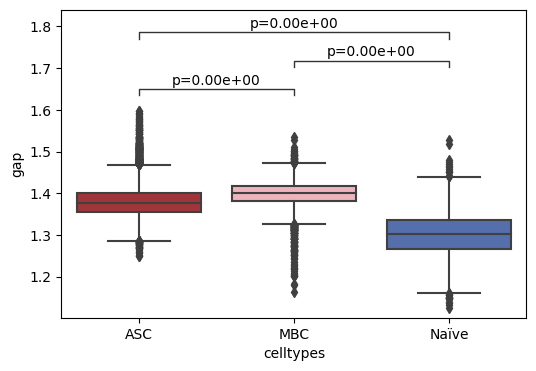

In [167]:
gap = pd.DataFrame({'gap': (torch.cdist(torch.from_numpy(bcremb), torch.from_numpy(gexemb))).diagonal().numpy(), 
                     'celltypes':metadata.population.tolist(), "timepoint":metadata.timepoint.tolist(),
                   "binding2": metadata.binding2.tolist(), "isotype": metadata.isotype.tolist()})
gap['barcode'] = metadata.index.tolist()
gap = gap.set_index('barcode', inplace=False)
gap = gap.sort_values(by="gap", ascending=False)
threshold = gap['gap'].quantile(0.9)
gap['difference'] = 'Small'
gap.loc[gap['gap'] >= threshold, 'difference'] = 'Large'
gap = gap.loc[bcrfile.index.tolist()]
assert(gap.index.tolist() == bcrfile.index.tolist())
#gap.to_csv("gap.csv")

plt.figure(figsize=(6,4)) 
g = sns.boxplot(data=gap, x='celltypes', y='gap', palette=['#B3242A', '#F8A9B7', '#4569BB'])

plotting_parameters = {
        'data': gap,
        'x': 'celltypes',
        'y': 'gap',
        'order':["MBC","ASC","Naïve"],
    }

MBC = gap[gap.celltypes == "MBC"].gap.values
ASC = gap[gap.celltypes == "ASC"].gap.values
Naive = gap[gap.celltypes == "Naïve"].gap.values

pvalues = [
    stats.mannwhitneyu(MBC, ASC, alternative="two-sided").pvalue,
    stats.mannwhitneyu(MBC, Naive, alternative="two-sided").pvalue,
    stats.mannwhitneyu(ASC, Naive, alternative="two-sided").pvalue,
]

candidate_pairs = [("MBC","ASC"),("MBC","Naïve"),
                    ("ASC","Naïve")]
pairs = []
formatted_pvalues = []
for idx in np.where(np.array(pvalues)<1)[0]:
    pairs.append(candidate_pairs[idx.item()])
    formatted_pvalues.append(f'p={pvalues[idx.item()]:.2e}')
print(formatted_pvalues)
if pairs:
    annotator = Annotator(g, pairs,**plotting_parameters)
    annotator.configure(loc="inside",line_height=0.03,line_width=1)
    annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()

plt.savefig("/mnt/d/unifiedBCR/figures/GSE244297/gap_celltypes.pdf", bbox_inches='tight')

In [5]:
from scipy.stats import fisher_exact, chi2_contingency

def count_kmers(sequences, k=2):
    kmer_dict = {}
    
    # Iterate through each sequence
    for seq in sequences:
        # Convert sequence to uppercase to standardize
        seq = seq.upper()[3:-3]
        
        # Slide through the sequence with window size k
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            # Add to dictionary or increment count
            kmer_dict[kmer] = kmer_dict.get(kmer, 0) + 1
            
    return kmer_dict

def compare_kmers(dict1, dict2, n_query_cdr3, n_ref_cdr3, alpha=0.05):
    """
    Compare k-mer frequencies between two dictionaries using Fisher's exact test
    
    Parameters:
    dict1 (dict): First k-mer dictionary
    dict2 (dict): Second k-mer dictionary
    alpha (float): Significance level for p-value cutoff (default: 0.05)
    
    Returns:
    pd.DataFrame: DataFrame containing k-mers, their counts, odds ratios, and p-values
    """
    # Get all unique k-mers
    all_kmers = sorted(set(list(dict1.keys()) + list(dict2.keys())))
    
    results = []
    
    # Perform Fisher's exact test for each k-mer
    for kmer in all_kmers:
        count1 = dict1.get(kmer, 0)
        count2 = dict2.get(kmer, 0)
        
        # Create contingency table
        contingency = np.array([[count1, n_query_cdr3 - count1],
                              [count2, n_ref_cdr3 - count2]])
        
        expected = np.array([n_query_cdr3*(count1+count2)/(n_query_cdr3+n_ref_cdr3), n_query_cdr3*(n_query_cdr3 - count1+n_ref_cdr3 - count2)/(n_query_cdr3+n_ref_cdr3),
              n_ref_cdr3*(count1+count2)/(n_query_cdr3+n_ref_cdr3), n_ref_cdr3*(n_query_cdr3 - count1+n_ref_cdr3 - count2)/(n_query_cdr3+n_ref_cdr3)])
        
        if np.sum(expected < 5) > 1:
            # Perform Fisher's exact test
            odds_ratio, pvalue = fisher_exact(contingency)
            test_used = 'Fisher'
        else:
            # Use Chi-square test
            odds_ratio, pvalue, _, _ = chi2_contingency(contingency)
            test_used = 'Chi-square'
        
        results.append({
            'kmer': kmer,
            'count1': count1,
            'count2': count2,
            'freq1': count1/n_query_cdr3 if n_query_cdr3 > 0 else 0,
            'freq2': count2/n_ref_cdr3 if n_ref_cdr3 > 0 else 0,
            'odds_ratio': odds_ratio,
            'pvalue': pvalue,
            'test_used': test_used,
            'significant': pvalue < alpha
        })
    
    # Convert to DataFrame and sort by p-value
    df = pd.DataFrame(results)
    df = df.sort_values('pvalue')
    df = df[df.pvalue <= alpha]
    
    return df

In [170]:
targetdict = count_kmers(bcrfile.loc[cohort, 'cdr3'].unique(), k=3)
controldict = count_kmers(list(set(bcrfile.loc[control, 'cdr3'].unique()) - set(bcrfile.loc[cohort, 'cdr3'].unique())), k=3)
compare_kmers(targetdict, controldict, len(bcrfile.loc[cohort, 'cdr3'].unique()), len(list(set(bcrfile.loc[control, 'cdr3'].unique()) - set(bcrfile.loc[cohort, 'cdr3'].unique()))), alpha=0.05)

,kmer,count1,count2,freq1,freq2,odds_ratio,pvalue,test_used,significant
1714,VAA,4,3,0.181818,0.007576,28.575764,9.010293e-08,Chi-square,True
1826,VVV,4,3,0.181818,0.007576,28.575764,9.010293e-08,Chi-square,True
1817,VVA,3,3,0.136364,0.007576,16.178994,5.762966e-05,Chi-square,True
791,IVV,3,4,0.136364,0.010101,13.239572,2.741004e-04,Chi-square,True
262,DYD,2,1,0.090909,0.002525,39.500000,7.696677e-03,Fisher,True
1212,PYF,2,2,0.090909,0.005051,19.700000,1.490114e-02,Fisher,True
1835,VYY,2,3,0.090909,0.007576,13.100000,2.404304e-02,Fisher,True
1991,YPG,2,4,0.090909,0.010101,4.755765,2.920032e-02,Chi-square,True
584,GRR,2,4,0.090909,0.010101,4.755765,2.920032e-02,Chi-square,True
601,GSY,3,12,0.136364,0.030303,4.057646,4.397175e-02,Chi-square,True


In [12]:
targetdict = count_kmers(bcrfile.loc[cohort, 'cdr3'].unique(), k=4)
controldict = count_kmers(bcrfile.loc[control, 'cdr3'].unique(), k=4)
df = compare_kmers(targetdict, controldict, len(bcrfile.loc[cohort, 'cdr3'].unique()), len(bcrfile.loc[control, 'cdr3'].unique()), alpha=0.05)
df

,kmer,count1,count2,freq1,freq2,odds_ratio,pvalue,test_used,significant
2649,VVVA,3,1,0.071429,0.002660,28.846154,0.003532,Fisher,True
1170,IVVV,3,1,0.071429,0.002660,28.846154,0.003532,Fisher,True
2630,VVAA,3,2,0.071429,0.005319,14.384615,0.008209,Fisher,True
2787,YDYY,2,0,0.047619,0.000000,inf,0.009879,Fisher,True
2768,YDIL,2,1,0.047619,0.002660,18.750000,0.027738,Fisher,True


In [23]:
targetdict = count_kmers(bcrfile.loc[cohort, 'cdr3'].unique(), k=4)
controldict = count_kmers(list(set(bcrfile.loc[control, 'cdr3'].unique()) - set(bcrfile.loc[cohort, 'cdr3'].unique())), k=4)
df = compare_kmers(targetdict, controldict, len(bcrfile.loc[cohort, 'cdr3'].unique()), len(list(set(bcrfile.loc[control, 'cdr3'].unique()) - set(bcrfile.loc[cohort, 'cdr3'].unique()))), alpha=0.05)
df

,kmer,count1,count2,freq1,freq2,odds_ratio,pvalue,test_used,significant
2649,VVVA,3,1,0.071429,0.002660,28.846154,0.003532,Fisher,True
1170,IVVV,3,1,0.071429,0.002660,28.846154,0.003532,Fisher,True
2630,VVAA,3,2,0.071429,0.005319,14.384615,0.008209,Fisher,True
2787,YDYY,2,0,0.047619,0.000000,inf,0.009879,Fisher,True
2768,YDIL,2,1,0.047619,0.002660,18.750000,0.027738,Fisher,True


In [9]:
targetdict = count_kmers(bcrfile.loc[cohort, 'cdr3'].unique(), k=5)
controldict = count_kmers(list(set(bcrfile.loc[control, 'cdr3'].unique()) - set(bcrfile.loc[cohort, 'cdr3'].unique())), k=5)
df = compare_kmers(targetdict, controldict, len(bcrfile.loc[cohort, 'cdr3'].unique()), len(list(set(bcrfile.loc[control, 'cdr3'].unique()) - set(bcrfile.loc[cohort, 'cdr3'].unique()))), alpha=0.05)
df

,kmer,count1,count2,freq1,freq2,odds_ratio,pvalue,test_used,significant
2650,VVVAA,3,1,0.069767,0.002639,28.350000,0.003685,Fisher,True
1182,IVVVA,2,0,0.046512,0.000000,inf,0.010165,Fisher,True
2761,YDILT,2,1,0.046512,0.002639,18.439024,0.028511,Fisher,True


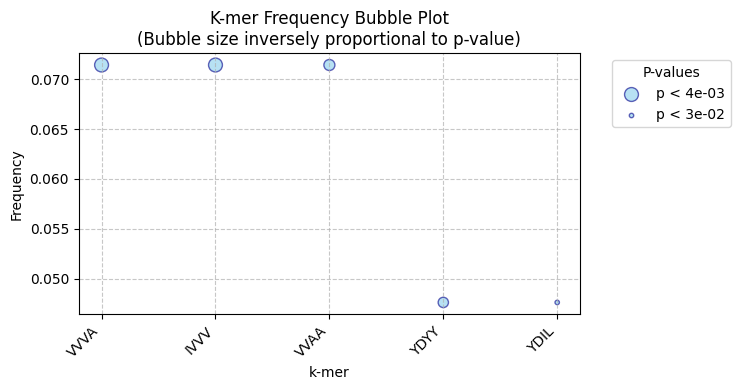

In [28]:
def create_bubble_plot(df, figsize=(6, 4), min_bubble_size=10, max_bubble_size=100):
    """
    Create a bubble plot where:
    - x-axis: kmers
    - y-axis: freq1
    - bubble size: inversely proportional to p-value (smaller p-values = larger bubbles)
    
    Parameters:
    df: DataFrame with columns 'kmer', 'freq1', 'pvalue'
    figsize: tuple for figure size
    min_bubble_size: minimum size for bubbles
    max_bubble_size: maximum size for bubbles
    """
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate bubble sizes: -log10(pvalue) for better visualization
    # Add small constant to avoid log(0)
    sizes = -np.log10(df['pvalue'] + 1e-300)
    
    # Normalize sizes to desired range
    sizes_normalized = ((sizes - sizes.min()) * (max_bubble_size - min_bubble_size) / 
                       (sizes.max() - sizes.min()) + min_bubble_size)
    
    # Create scatter plot
    scatter = ax.scatter(range(len(df)), df['freq1'], 
                        s=sizes_normalized, 
                        alpha=0.6,
                        c='skyblue',
                        edgecolor='darkblue')
    
    # Customize plot
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df['kmer'], rotation=45, ha='right')
    
    # Add labels and title
    ax.set_xlabel('k-mer')
    ax.set_ylabel('Frequency')
    ax.set_title('K-mer Frequency Bubble Plot\n(Bubble size inversely proportional to p-value)')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Add legend for bubble sizes
    legend_elements = [plt.scatter([], [], s=sizes_normalized.max(), 
                                 c='skyblue', alpha=0.6, 
                                 edgecolor='darkblue', 
                                 label=f'p < {df["pvalue"].min():.0e}'),
                      plt.scatter([], [], s=sizes_normalized.min(), 
                                c='skyblue', alpha=0.6, 
                                edgecolor='darkblue', 
                                label=f'p < {df["pvalue"].max():.0e}')]
    
    ax.legend(handles=legend_elements, 
             title='P-values',
             bbox_to_anchor=(1.05, 1),
             loc='upper left')
    
    return fig, ax


# Create the plot
fig, ax = create_bubble_plot(df)
plt.savefig("/mnt/d/unifiedBCR/figures/GSE244297/4mer.pdf", bbox_inches='tight')
